In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split



RANDOM_SEED = 42

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
#在模型设置中的输出层用到
NUM_CLASSES = 4

# Dataset reading

In [5]:
#二维数组，每一行表示一个样本（一个手势的21个点坐标集合），每一列表示一个关键点的坐标。
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
#只读取数据集的第一列，即标签列。
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
#训练集占总数据集的75%，测试集占25%
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
#定义了一个Keras的Sequential模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),  #定义输入数据的形状
    tf.keras.layers.Dropout(0.2),   #防止过拟合的层，以0.2的概率随机丢弃一些神经元。
    tf.keras.layers.Dense(20, activation='relu'),   #全连接层，包含20个神经元，使用ReLU激活函数。
    tf.keras.layers.Dropout(0.4),   #防止过拟合的层,以0.4的概率随机丢弃一些神经元。
    tf.keras.layers.Dense(10, activation='relu'),   #全连接层，包含10个神经元，使用ReLU激活函数
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    #最后的输出层，包含了4个神经元，使用softmax激活函数，将输出结果转化为概率值。
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


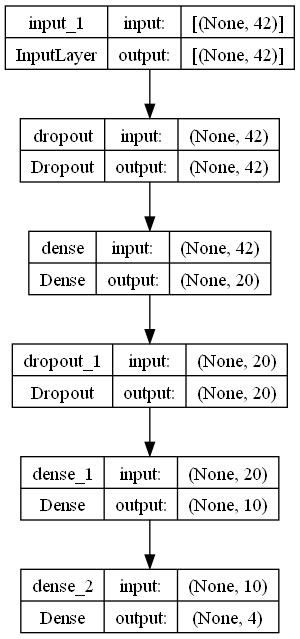

In [9]:
model.summary()  
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
# 在每个epoch结束时保存模型的权重和架构
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 监测验证集上的性能，并在连续20个epoch性能没有提升时停止训练，以避免过拟合和浪费计算资源。
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# 模型编译
model.compile(
    optimizer='adam',   #优化器（optimizer）：用于优化模型参数以最小化损失函数。选择Adam优化器。
    loss='sparse_categorical_crossentropy', #损失函数（loss）：用于评估模型在训练期间的性能。选择稀疏分类交叉熵损失函数（sparse_categorical_crossentropy）。
    metrics=['accuracy']    #用于评估模型性能的指标。选择准确度（accuracy）作为指标。
)

# Model training

In [12]:
model.fit(
    X_train,    #训练数据集的输入特征。
    y_train,    #训练数据集的标签。
    epochs=1000,    #迭代次数。
    batch_size=128, #每个 batch 中的样本数
    validation_data=(X_test, y_test),   #验证集数据
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
23/29 [======================>.......] - ETA: 0s - loss: 1.4487 - accuracy: 0.2714
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
29/29 [==============================] - 2s 15ms/step - loss: 1.4401 - accuracy: 0.2724 - val_loss: 1.3368 - val_accuracy: 0.3150
Epoch 2/1000
23/29 [======================>.......] - ETA: 0s - loss: 1.3533 - accuracy: 0.2972
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
29/29 [==============================] - 0s 8ms/step - loss: 1.3486 - accuracy: 0.2997 - val_loss: 1.2898 - val_accuracy: 0.3926
Epoch 3/1000
21/29 [====================>.........] - ETA: 0s - loss: 1.3003 - accuracy: 0.3281
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
29/29 [==============================] - 0s 8ms/step - loss: 1.2939 - accuracy: 0.3362 - val_loss: 1.2383 - val_accuracy: 0.4511
Epoch 4/1000
26/29 [=========================>....] - ETA: 0s - loss: 1.2447 - accuracy: 0.3585


In [13]:
# 评估模型
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 4ms/step - loss: 0.1835 - accuracy: 0.9766


In [14]:
# 保存模型
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 104ms/step
[9.7560388e-01 2.4133213e-02 5.2368523e-05 2.1054619e-04]
0


# Confusion matrix（混淆矩阵）

38/38 [==============================] - 0s 2ms/step


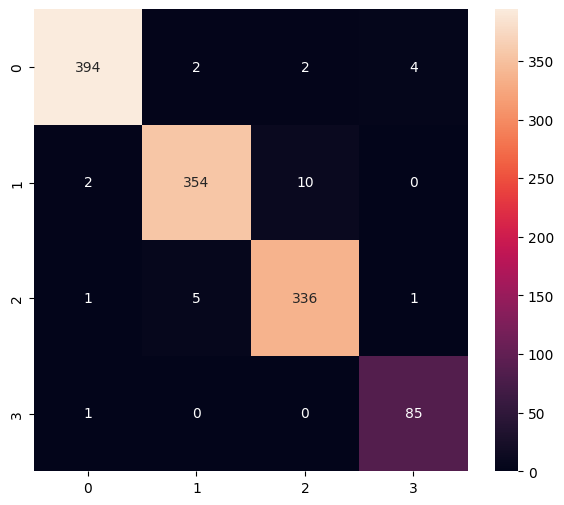

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       402
           1       0.98      0.97      0.97       366
           2       0.97      0.98      0.97       343
           3       0.94      0.99      0.97        86

    accuracy                           0.98      1197
   macro avg       0.97      0.98      0.97      1197
weighted avg       0.98      0.98      0.98      1197



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# 将训练好的模型保存为一个可供后续推理使用的模型
model.save(model_save_path, include_optimizer=False)

In [18]:
# 量化模型

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_t3klc6d\assets


6544

# Inference test（推断测试）

In [18]:
# interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
# interpreter.allocate_tensors()

In [19]:
# # Get I / O tensor
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

In [20]:
# interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
# %%time
# # Inference implementation
# interpreter.invoke()
# tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [22]:
# print(np.squeeze(tflite_results))
# print(np.argmax(np.squeeze(tflite_results)))